In [1]:
import os
import sys
import numpy as np
sys.path.insert(0, "/home/bnapp/arivkindNet/wisdrc/")
from parse_commandline import parse_commandline
from utils.imagenet_dataset import get_dataset
from utils.unprocess import *
from utils.image_utils import *
from utils.image_processing import rescale
from utils.split_keras_model import split_model

import tensorflow as tf
import matplotlib.pyplot as plt

/usr/local/lib/python3.8/dist-packages/tensorflow_addons/utils/ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.3.0 and strictly below 2.6.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.6.0 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you want to make sure you're using a tested and supported configuration, either change the TensorFlow version or the TensorFlow Addons's version. 
You can find the compatibility matrix in TensorFlow Addon's readme:
https://github.com/tensorflow/addons
  warnings.warn(


In [2]:
import pickle as pkl

In [3]:
#define function to calculate equal-frequency bins 
#taken from: https://www.statology.org/equal-frequency-binning-python/
def equal_freq_bins(x, nbin):
    nlen = len(x)
    return np.interp(np.linspace(0, nlen, nbin + 1),
                     np.arange(nlen),
                     np.sort(x))

def equal_freq_bins_for_batch(feature_map,nbins):
    bin_edges = []
    for feature in feature_map.transpose([3,0,1,2]):
            bin_edges.append(
                equal_freq_bins(np.reshape(feature,[-1]),nbins)
            )
    bin_edges = np.array(bin_edges)
    return bin_edges

def init_bins(n_features, bin_edges):
    """
    TODO: Vectorize.
    See sec. 3.1 in https://arxiv.org/abs/1806.06988 for details on the soft binning procedure.
    """
    # Init bins using super class
#     super(SoftBinStats, self).init_bins()

    # Define W + b for soft binning
    inner_edges = bin_edges[:, 1:-1]           # soft binning method using n "inner" edges for n+1 intervals
    n_edges = inner_edges.shape[1]
#         dev = self.bin_edges.device
    W = []
    b = []
    for f in range(n_features):
        w_ = tf.reshape(tf.linspace(1, n_edges + 1, n_edges + 1), [1, -1])
        b_ = tf.math.cumsum(tf.concat([tf.zeros([1]), -inner_edges[f]], 0), 0)
        W.append(w_)
        b.append(b_)
    W = tf.reshape(tf.stack(W),(n_features, 1, n_edges + 1))  # reshape for matmul later
    b = tf.reshape(tf.stack(b),(n_features, 1, n_edges + 1))  # reshape for matmul later
    return W,b

def generate_random_couplings(n,k,discard_diagonal=False):
    M=np.random.uniform(size=(n,n))
    if discard_diagonal:
        raise NotImplemented
    return np.argwhere(M<k/(n**2))

def mesh_sum(a,b,axis=-1):
    #take two tensors of the same size
    #let the last dimensio of tensor a be (a1,a2,a3,a4)
    #and of tensor b (b1,b2,b3,b4)
    #returns:
    #a1+b1,... a4+b1, 
    #a2+b2 ... a4+b2
    #... 
    #a4+b1  ... a4+b4
    if axis != -1:
        raise NotImplemented
        
    a_shape = tf.shape(a)
    a_tile_times = tf.concat([a_shape[:-1]*0+1,a_shape[-1:]],axis=0)
    a = tf.tile(a,a_tile_times)

    b_shape = tf.shape(b)
    b_tile_times = tf.concat([b_shape*0+1,b_shape[-1:]],axis=0)
    b_target_shape = tf.concat([b_shape[:-1],[-1]],axis=0)
    b = tf.tile(b[...,tf.newaxis],b_tile_times)
    b = tf.reshape(b,b_target_shape)
    
    return a+b



def get_soft_batch_counts(x, n_features, bin_edges, norm_inputs=False, tau=0.1, norm_output=True):
    """ See Neural Decision Forests paper for details on the soft binning procedure. """
    # Conv: [B, H, W, C] --> [C, BxHxW], FC: [B, C] --> [C, B]
    W,b = init_bins(n_features, bin_edges)
    
    x = tf.transpose(x,[3,0,1,2])
    x = tf.reshape(x,[n_features,-1])
    if norm_inputs:
        raise NotImplemented
#         x = norm_inputs(x)
        
    x = tf.reshape(x,(n_features, -1, 1))         # reshape for make-shift batch outer prod via matmul

    # Calculate "logits" per sample via batch outer-product.
    # x:[n_features, n_samples, 1] x W:[n_features, 1, n_bins] = [n_features, n_samples, n_bins]
#     z = tf.matmul(x, W) + b
    z = tf.matmul(x, tf.cast(W,dtype=tf.float32)) + b

    # Calculate soft allocations per sample ("soft" --> sum to 1)
    sft_cs = tf.nn.softmax(z / tau, axis=2)  # [n_features, n_samples, n_bins]

    # Sum over samples to get total soft counts ("soft" --> real number)
    total_sft_cs = tf.reduce_sum(sft_cs,axis=1)

    if norm_output:
        total_sft_cs = total_sft_cs / tf.reduce_sum(total_sft_cs,axis=1,keepdims=True )
        
    return total_sft_cs

def get_soft_batch_counts_sparse2D(x, n_features, bin_edges, couplings=[], norm_inputs=False, tau=0.1, norm_output=True):
    """ TODO: REFACTOR, very similar to the 1D binning. maybe turn to class with inherence? """
    # Conv: [B, H, W, C] --> [C, BxHxW], FC: [B, C] --> [C, B]
    W,b = init_bins(n_features, bin_edges)
    
    x = tf.transpose(x,[3,0,1,2])
    x = tf.reshape(x,[n_features,-1])
    if norm_inputs:
        raise NotImplemented
        
    x = tf.reshape(x,(n_features, -1, 1))         # reshape for make-shift batch outer prod via matmul

    # Calculate "logits" per sample via batch outer-product.
    # x:[n_features, n_samples, 1] x W:[n_features, 1, n_bins] = [n_features, n_samples, n_bins]
#     z = tf.matmul(x, W) + b
    z = tf.matmul(x, tf.cast(W,dtype=tf.float32)) + b
    
    z_couplings = []
    for couple in couplings: 
        z_couplings.append(mesh_sum(z[couple[0],...],z[couple[1],...]))
    
    z_couplings = tf.stack(z_couplings,axis=0)
    # Calculate soft allocations per sample ("soft" --> sum to 1)
    sft_cs = tf.nn.softmax(z_couplings / tau, axis=2)  # [n_features, n_samples, n_bins]

    
    # Sum over samples to get total soft counts ("soft" --> real number)
    total_sft_cs = tf.reduce_sum(sft_cs,axis=1)

    if norm_output:
        total_sft_cs = total_sft_cs / tf.reduce_sum(total_sft_cs,axis=1,keepdims=True )
        
    return total_sft_cs

def keras_loss_for_soft_binning(ref_feature_hist,
                                n_features,
                                bin_edges,
                                couplings=[], 
                                tau=0.1,
                                loss_type='SKLD',
                                mode='1D'):
    kl = tf.keras.losses.KLDivergence()
    def loss_fun(y_true,y_pred):
        #here y_true is a sham input. the reference distribution is fixed for all batches
        if mode=='1D':
            soft_feature_hist=get_soft_batch_counts(y_pred, 
                           n_features, 
                           bin_edges,
                           norm_inputs=False,
                          tau=tau)
        elif mode=='sparse2D':
            soft_feature_hist=get_soft_batch_counts_sparse2D(y_pred, 
                           n_features, 
                           bin_edges,
                            couplings = couplings,
                           norm_inputs=False,
                          tau=tau)
        else:
            raise NotImplementedError
                    
        if loss_type == 'SKLD':
            loss = 0.5*(kl(soft_feature_hist,ref_feature_hist) + kl(ref_feature_hist,soft_feature_hist))
        else:
            raise NotImplementedError
        return loss
    return loss_fun
        

In [4]:
def feature_histogram(feature_map,bin_range=[0,10],nbins=10):
    feature_hist = []
    feature_map_tf = tf.constant(feature_map) 
    for feature in feature_map.transpose([3,0,1,2]):
        hist = tf.histogram_fixed_width(tf.reshape(feature,[-1]),bin_range,nbins=nbins)
        hist = hist/tf.reduce_sum(hist)
        feature_hist.append(tf.cast(hist,dtype=tf.float32))
    return feature_hist

In [5]:
parser = parse_commandline(return_parser=True)
config = parser.parse_args([])
config = vars(config)
parameters = config

In [6]:
batch_size = 64

In [7]:
teacher = tf.keras.applications.resnet.ResNet50(input_shape=(224, 224, 3),
                                                      include_top=True,
                                                      weights='imagenet')
split_after_layer = 'pool1_pool'

2023-04-17 06:04:59.463391: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1917] Ignoring visible gpu device (device: 1, name: NVIDIA GeForce GT 730, pci bus id: 0000:65:00.0, compute capability: 3.5) with core count: 2. The minimum required count is 8. You can adjust this requirement with the env var TF_MIN_GPU_MULTIPROCESSOR_COUNT.
2023-04-17 06:04:59.879058: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1510] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 1412 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1080 Ti, pci bus id: 0000:17:00.0, compute capability: 6.1


In [8]:
teacher.compile(loss="categorical_crossentropy",
                metrics=["categorical_accuracy", "top_k_categorical_accuracy"],
                )
fe_model, be_model = split_model(teacher, split_after_layer)

In [9]:
val_generator_baseline = get_dataset(parameters['dataset_dir'], 'validation', batch_size, central_squeeze_and_pad_factor=-1, preprocessing=parameters['preprocessing'])


Instructions for updating:
Use `tf.data.Dataset.map(map_func, num_parallel_calls)` followed by `tf.data.Dataset.batch(batch_size, drop_remainder)`. Static tf.data optimizations will take care of using the fused implementation.


In [10]:
for ii,batch in enumerate(val_generator_baseline):
    feature_map = fe_model.predict(batch[0])
    if ii>0:
        break


2023-04-17 06:05:02.656738: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2023-04-17 06:05:11.912094: I tensorflow/stream_executor/cuda/cuda_dnn.cc:381] Loaded cuDNN version 8300


/tmp/ipykernel_16473/2031923291.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()


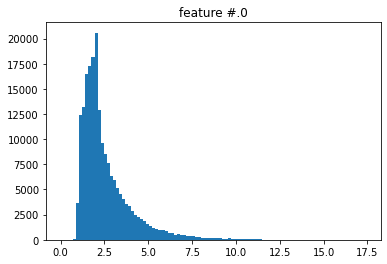

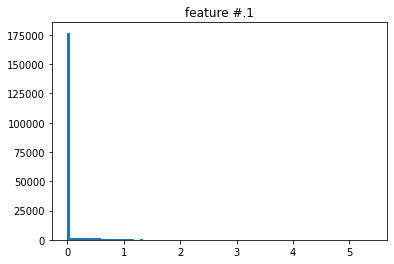

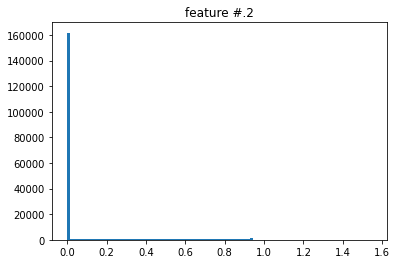

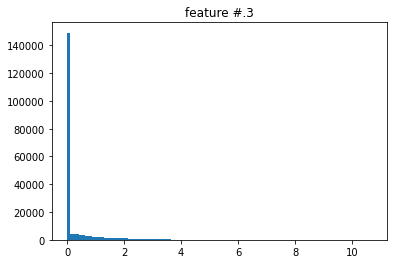

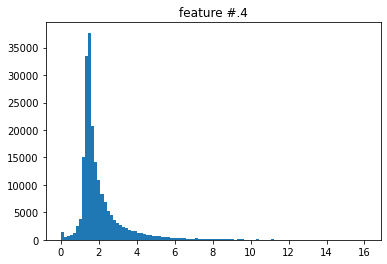

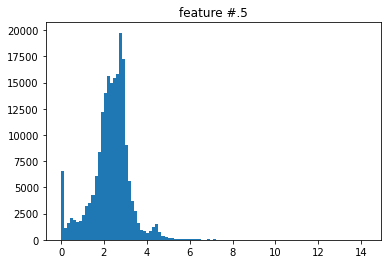

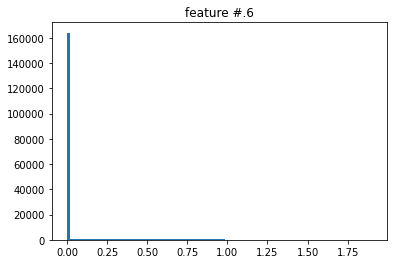

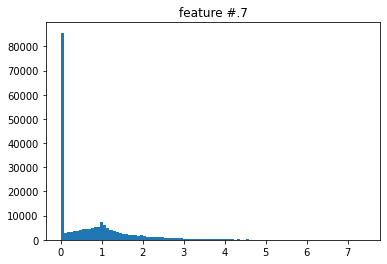

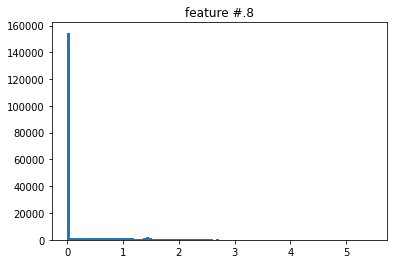

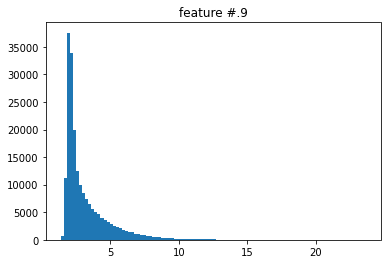

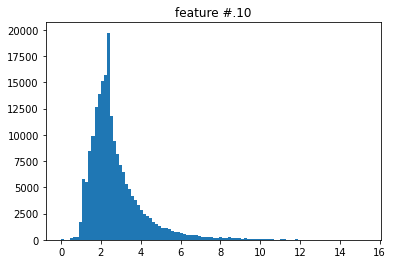

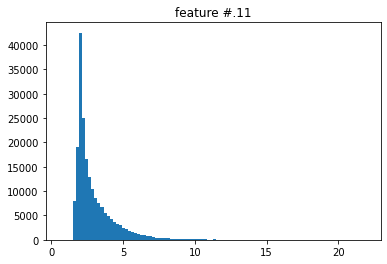

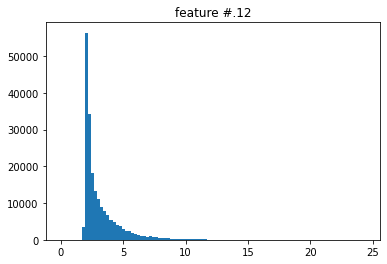

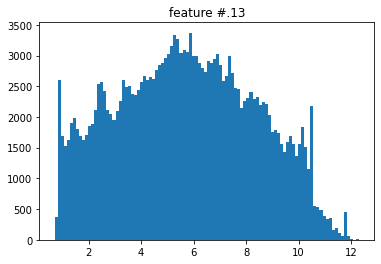

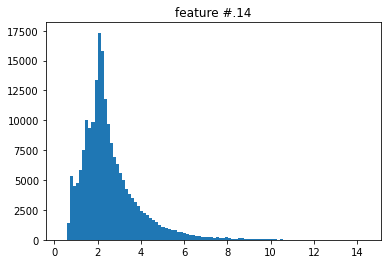

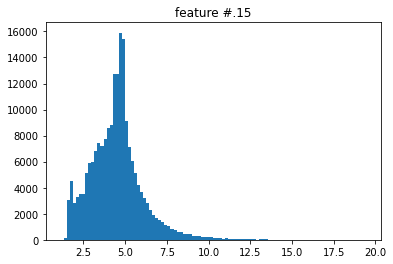

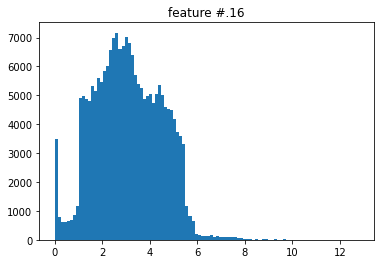

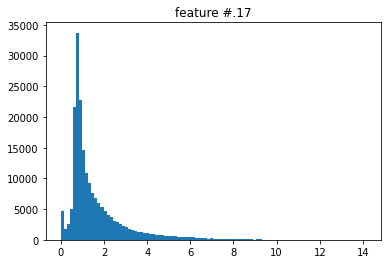

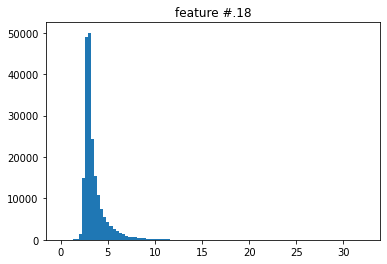

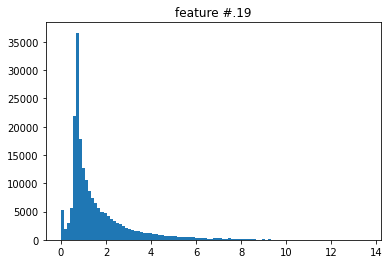

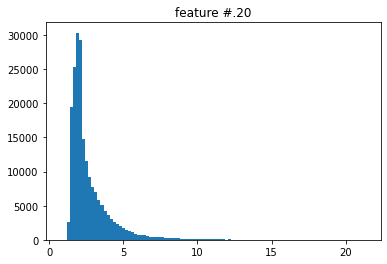

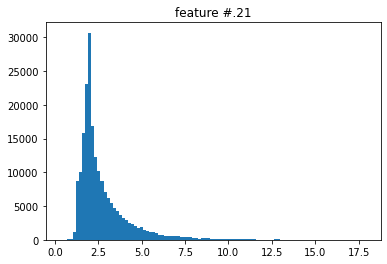

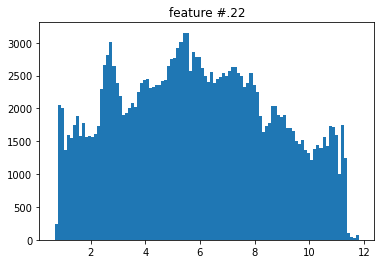

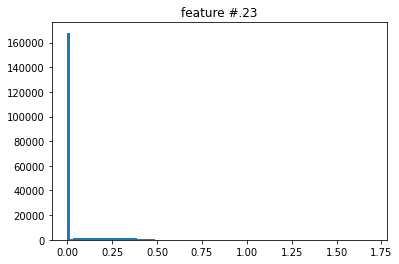

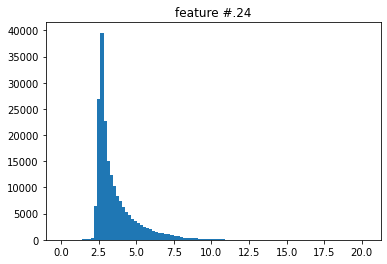

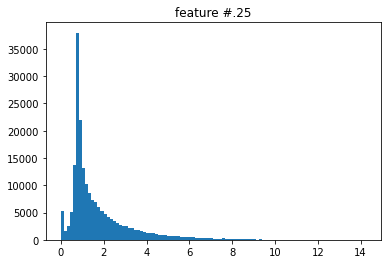

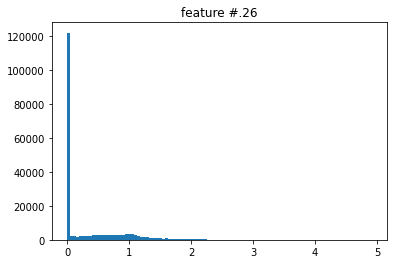

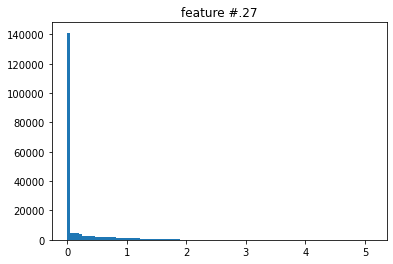

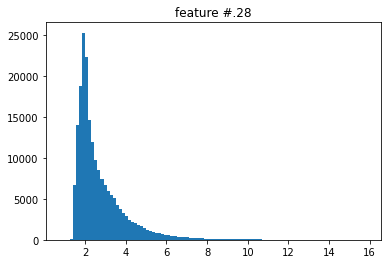

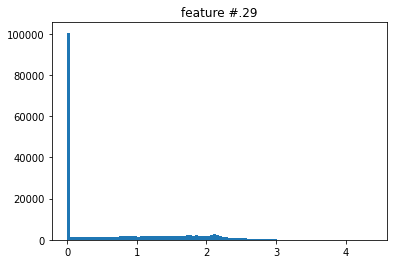

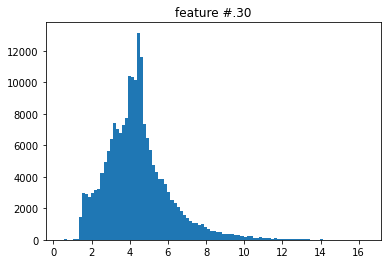

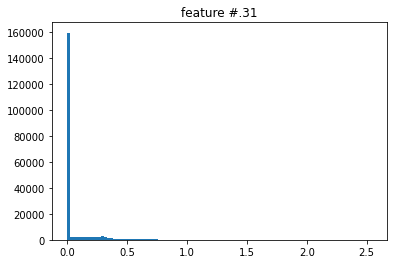

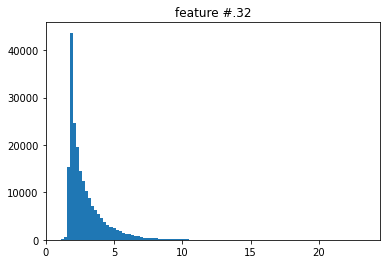

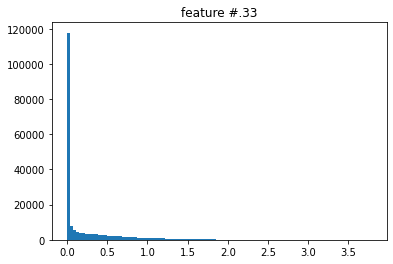

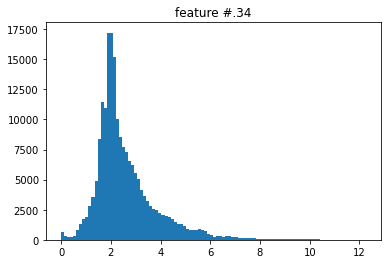

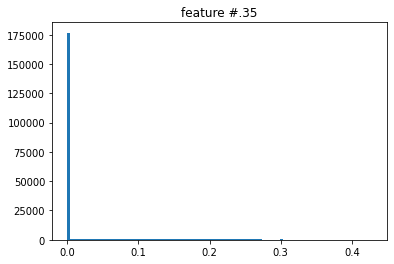

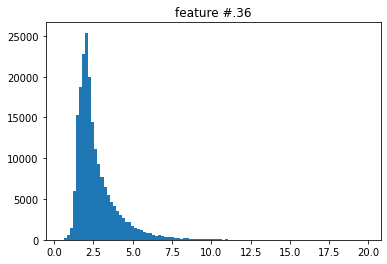

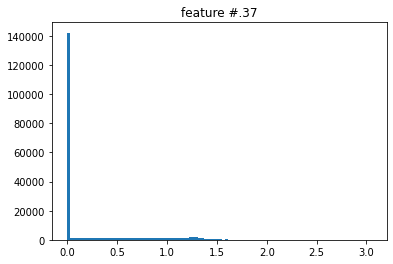

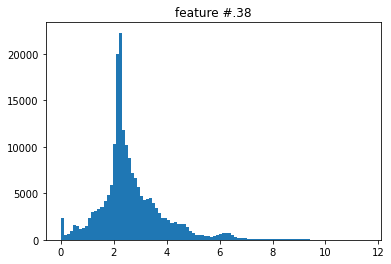

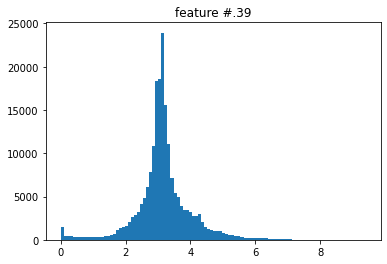

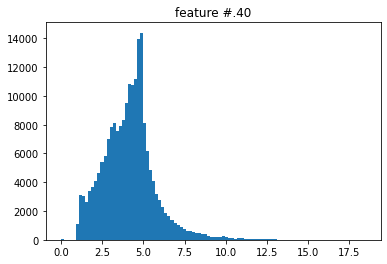

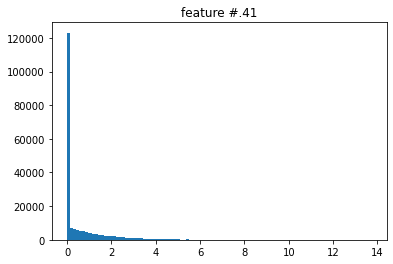

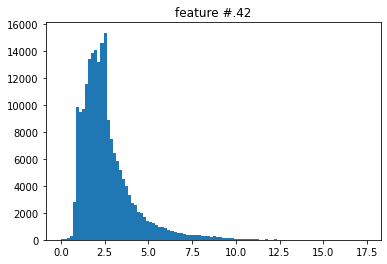

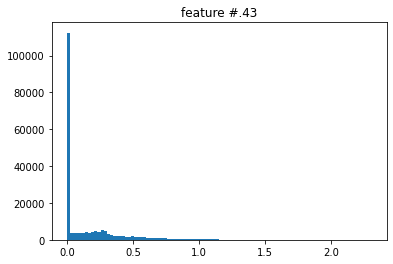

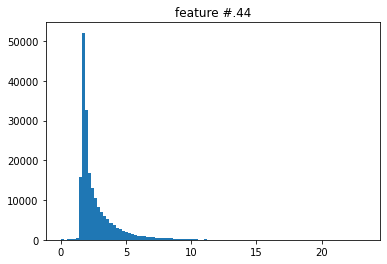

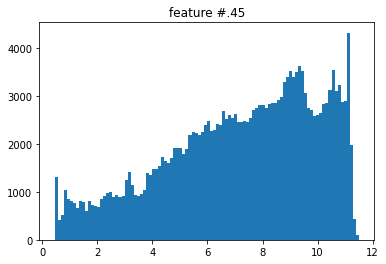

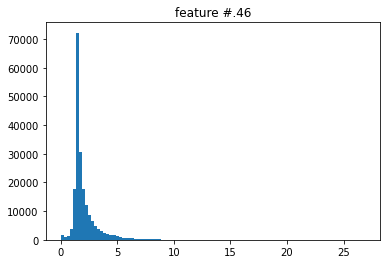

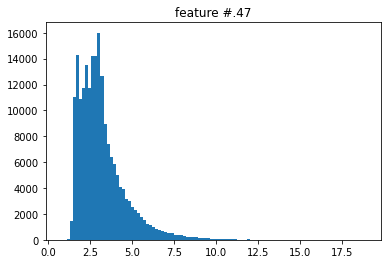

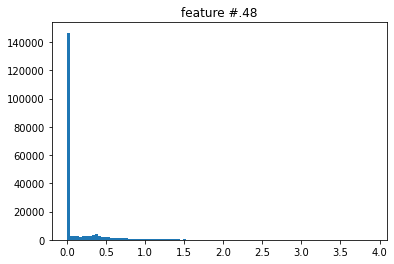

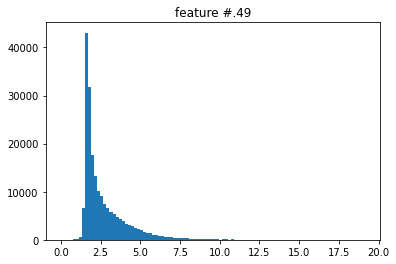

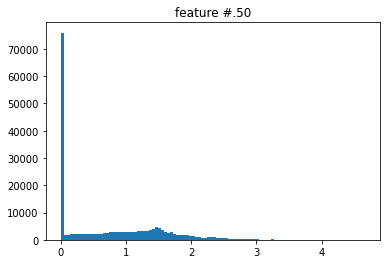

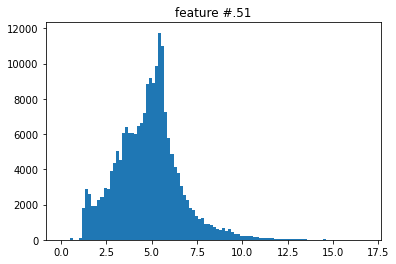

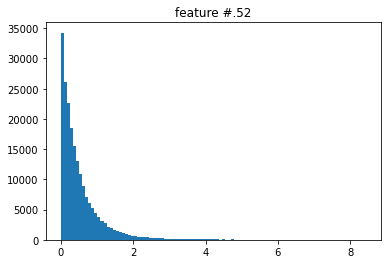

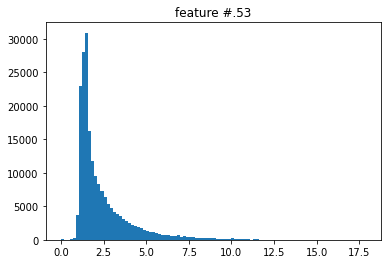

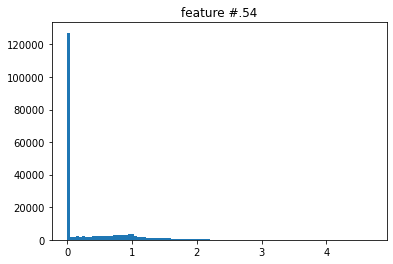

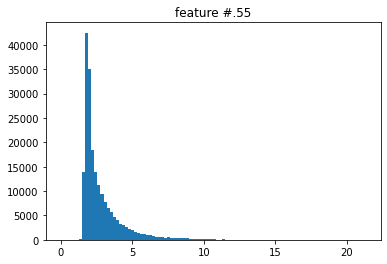

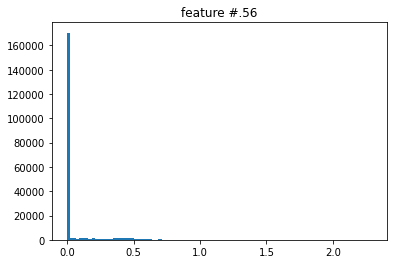

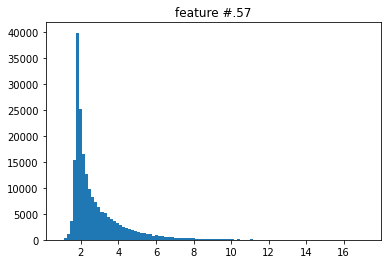

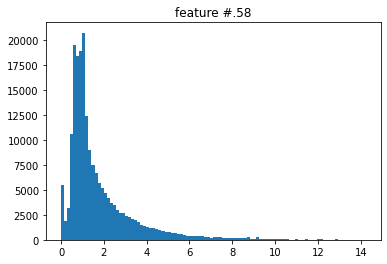

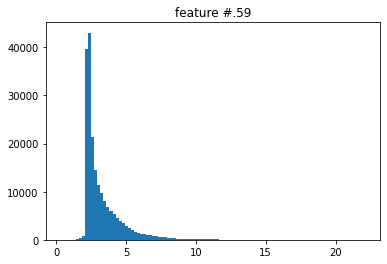

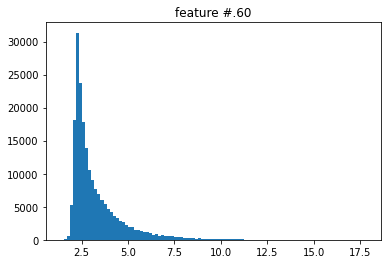

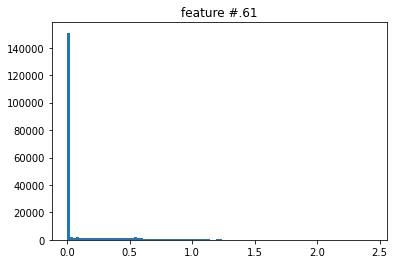

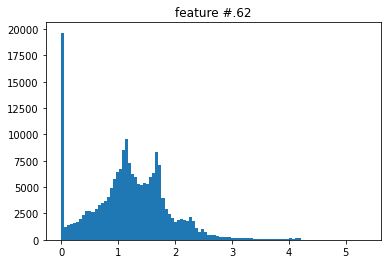

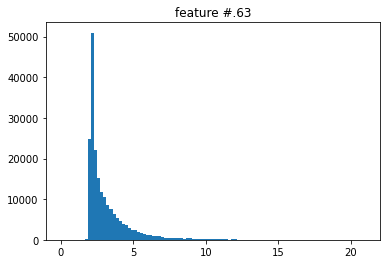

In [11]:
for ff in range(64):
    plt.figure()
    _ = plt.hist(feature_map[:,:,:,ff].reshape([-1]),bins=100)
    plt.title('feature #.{}'.format(ff))



In [12]:
n_features = 64
n_bins = 10
n_bins_2D = 3
binning_noise = 1e-5 #currently not in use. consider using it to avoid degenerated bins at zero

In [13]:
bin_edges =  equal_freq_bins_for_batch(feature_map
                                       ,n_bins)
bin_edges_2D =  equal_freq_bins_for_batch(feature_map,
                                          n_bins_2D)

In [14]:
bin_edges

array([[2.95914505e-02, 1.28979082e+00, 1.53745081e+00, 1.73547153e+00,
        1.92848458e+00, 2.09875107e+00, 2.38414025e+00, 2.80306025e+00,
        3.42332072e+00, 4.50083170e+00, 1.73857632e+01],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 2.13695714e-01, 5.39266729e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 4.52583534e-01, 1.54547429e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        3.86650205e-01, 1.18931198e+00, 1.06798878e+01],
       [0.00000000e+00, 1.24017553e+00, 1.35768828e+00, 1.44587660e+00,
        1.51729901e+00, 1.62270033e+00, 1.79008248e+00, 2.04573259e+00,
        2.47904611e+00, 3.42526932e+00, 1.60428505e+

In [15]:
soft_bins=get_soft_batch_counts(feature_map[:64], 
                           n_features, 
                           bin_edges,
                           norm_inputs=False,
                          tau=0.1)

2023-04-17 06:05:39.367257: W tensorflow/core/common_runtime/bfc_allocator.cc:463] Allocator (GPU_0_bfc) ran out of memory trying to allocate 490.00MiB (rounded to 513802240)requested by op Softmax
If the cause is memory fragmentation maybe the environment variable 'TF_GPU_ALLOCATOR=cuda_malloc_async' will improve the situation. 
Current allocation summary follows.
Current allocation summary follows.
2023-04-17 06:05:39.367366: I tensorflow/core/common_runtime/bfc_allocator.cc:1013] BFCAllocator dump for GPU_0_bfc
2023-04-17 06:05:39.367397: I tensorflow/core/common_runtime/bfc_allocator.cc:1020] Bin (256): 	Total Chunks: 116, Chunks in use: 116. 29.0KiB allocated for chunks. 29.0KiB in use in bin. 16.5KiB client-requested in use in bin.
2023-04-17 06:05:39.367418: I tensorflow/core/common_runtime/bfc_allocator.cc:1020] Bin (512): 	Total Chunks: 81, Chunks in use: 80. 40.5KiB allocated for chunks. 40.0KiB in use in bin. 40.0KiB client-requested in use in bin.
2023-04-17 06:05:39.367442

ResourceExhaustedError: OOM when allocating tensor with shape[64,200704,10] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc [Op:Softmax]

In [16]:
couplings = generate_random_couplings(n_features,
                                      2*n_features) #two links per feature

In [17]:
couplings

array([[ 0, 12],
       [ 0, 51],
       [ 0, 58],
       [ 1, 17],
       [ 2, 34],
       [ 2, 43],
       [ 2, 52],
       [ 4, 35],
       [ 4, 46],
       [ 8,  2],
       [ 8, 25],
       [ 8, 28],
       [ 8, 40],
       [11, 22],
       [12, 10],
       [12, 18],
       [12, 62],
       [13, 55],
       [15,  3],
       [15, 30],
       [16, 46],
       [17, 31],
       [17, 44],
       [18, 36],
       [18, 42],
       [18, 44],
       [19,  7],
       [19,  9],
       [19, 34],
       [19, 45],
       [20, 14],
       [20, 36],
       [20, 41],
       [20, 50],
       [21, 26],
       [21, 33],
       [21, 43],
       [21, 45],
       [21, 47],
       [21, 48],
       [21, 55],
       [22, 61],
       [23,  2],
       [23,  3],
       [24,  9],
       [24, 22],
       [24, 43],
       [24, 46],
       [24, 55],
       [27, 21],
       [28, 12],
       [28, 23],
       [28, 51],
       [29, 27],
       [29, 47],
       [29, 53],
       [30, 13],
       [30, 29],
       [30, 57

In [18]:
soft_bins_2D=get_soft_batch_counts_sparse2D(feature_map[:64], 
                           n_features, 
                           bin_edges_2D,
                        couplings=couplings,
                           norm_inputs=False,
                          tau=0.1)

2023-04-17 07:15:00.882075: W tensorflow/core/common_runtime/bfc_allocator.cc:463] Allocator (GPU_0_bfc) ran out of memory trying to allocate 49.00MiB (rounded to 51380224)requested by op Transpose
If the cause is memory fragmentation maybe the environment variable 'TF_GPU_ALLOCATOR=cuda_malloc_async' will improve the situation. 
Current allocation summary follows.
Current allocation summary follows.
2023-04-17 07:15:00.882199: I tensorflow/core/common_runtime/bfc_allocator.cc:1013] BFCAllocator dump for GPU_0_bfc
2023-04-17 07:15:00.882237: I tensorflow/core/common_runtime/bfc_allocator.cc:1020] Bin (256): 	Total Chunks: 118, Chunks in use: 117. 29.5KiB allocated for chunks. 29.2KiB in use in bin. 16.5KiB client-requested in use in bin.
2023-04-17 07:15:00.882263: I tensorflow/core/common_runtime/bfc_allocator.cc:1020] Bin (512): 	Total Chunks: 81, Chunks in use: 80. 40.5KiB allocated for chunks. 40.0KiB in use in bin. 40.0KiB client-requested in use in bin.
2023-04-17 07:15:00.882288

ResourceExhaustedError: OOM when allocating tensor with shape[64,64,56,56] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc [Op:Transpose]

t 7fdd5611b700 of size 512 next 837
2023-04-17 07:15:00.896862: I tensorflow/core/common_runtime/bfc_allocator.cc:1069] InUse at 7fdd5611b900 of size 1536 next 842
2023-04-17 07:15:00.896877: I tensorflow/core/common_runtime/bfc_allocator.cc:1069] Free  at 7fdd5611bf00 of size 197376 next 500
2023-04-17 07:15:00.896891: I tensorflow/core/common_runtime/bfc_allocator.cc:1069] InUse at 7fdd5614c200 of size 327680 next 495
2023-04-17 07:15:00.896909: I tensorflow/core/common_runtime/bfc_allocator.cc:1069] InUse at 7fdd5619c200 of size 262144 next 498
2023-04-17 07:15:00.896921: I tensorflow/core/common_runtime/bfc_allocator.cc:1069] Free  at 7fdd561dc200 of size 327680 next 352
2023-04-17 07:15:00.896931: I tensorflow/core/common_runtime/bfc_allocator.cc:1069] InUse at 7fdd5622c200 of size 8192000 next 368
2023-04-17 07:15:00.896940: I tensorflow/core/common_runtime/bfc_allocator.cc:1069] InUse at 7fdd569fc200 of size 2359296 next 539
2023-04-17 07:15:00.896950: I tensorflow/core/common_r

2023-04-17 07:15:00.898067: I tensorflow/core/common_runtime/bfc_allocator.cc:1077] 1 Chunks of size 513802240 totalling 490.00MiB
2023-04-17 07:15:00.898079: I tensorflow/core/common_runtime/bfc_allocator.cc:1077] 1 Chunks of size 584203776 totalling 557.14MiB
2023-04-17 07:15:00.898090: I tensorflow/core/common_runtime/bfc_allocator.cc:1081] Sum Total of in-use chunks: 1.35GiB
2023-04-17 07:15:00.898100: I tensorflow/core/common_runtime/bfc_allocator.cc:1083] total_region_allocated_bytes_: 1480589312 memory_limit_: 1480589312 available bytes: 0 curr_region_allocation_bytes_: 2961178624
2023-04-17 07:15:00.898116: I tensorflow/core/common_runtime/bfc_allocator.cc:1089] Stats: 
Limit:                      1480589312
InUse:                      1446660352
MaxInUse:                   1446660352
NumAllocs:                        5349
MaxAllocSize:                584203776
Reserved:                            0
PeakReserved:                        0
LargestFreeBlock:                    0



In [ ]:
import gc

In [ ]:
gc.collect()

In [ ]:
soft_bins_2D_debug=get_soft_batch_counts_sparse2D(feature_map[:64], 
                           n_features, 
                           bin_edges_2D,
                        couplings=[[5,13]],
                           norm_inputs=False,
                          tau=0.1)

In [ ]:
for ii,uu in enumerate(soft_bins_2D.numpy()):
    print(ii,uu.reshape([3,3]))
    print(ii,uu.sum())

In [ ]:
soft_bins_2D_debug.numpy().reshape([3,3])

In [ ]:
soft_bins_2D_debug.numpy().reshape([3,3]).sum(axis=0),soft_bins_2D_debug.numpy().reshape([3,3]).sum(axis=1)

In [ ]:
reference_feature_stats = {'stats': soft_bins.numpy(), 'bin_edges': bin_edges, 
                           'stats_2D': soft_bins_2D.numpy(), 'bin_edges_2D': bin_edges_2D,
                           'couplings': couplings}

In [ ]:
# with open('../data_files/reference_feature_stats_resnet50_eq10bins_3x3bins_256img_v1.pkl','wb') as f:
#     pkl.dump(reference_feature_stats,f) #this one was actually 64 images...

In [ ]:
# with open('../data_files/reference_feature_stats_resnet50_eq10bins_3x3bins_256img_v1.pkl','rb') as f:
#     reference_feature_stats = pkl.load(f)

In [ ]:
train_generator_baseline = get_dataset(parameters['dataset_dir'], 'train', batch_size, preprocessing=parameters['preprocessing'])


In [ ]:
for ii,batch in enumerate(train_generator_baseline):
    feature_map = fe_model.predict(batch[0])
    if ii>0:
        break

In [ ]:
bin_edges =  equal_freq_bins_for_batch(feature_map
                                       ,n_bins)
bin_edges_2D =  equal_freq_bins_for_batch(feature_map,
                                          n_bins_2D)

In [ ]:
train_generator_64 = get_dataset(parameters['dataset_dir'], 'train', 64, preprocessing=parameters['preprocessing'])


In [ ]:
loss1D_rec = []
loss2D_rec = []
accum_feature_stats = 0
accum_feature_stats_2D = 0
max_iter = 30
for ii,batch in enumerate(train_generator_64):
    feature_map = fe_model.predict(batch[0])
    if ii>max_iter:
        break
    print(ii)
    feature_stats = get_soft_batch_counts(feature_map, 
                           n_features, 
                           bin_edges,
                           norm_inputs=False,
                          tau=0.1)
    feature_stats_2D = get_soft_batch_counts_sparse2D(feature_map, 
                           n_features, 
                           bin_edges_2D,
                        couplings=couplings,
                           norm_inputs=False,
                          tau=0.1)
    accum_feature_stats = 1./(ii+1)*(accum_feature_stats *ii + feature_stats)
    accum_feature_stats_2D = 1./(ii+1)*(accum_feature_stats_2D *ii + feature_stats_2D)
    
    if ii>0:
        loss1D_rec.append(loss1D(999,feature_map))
        loss2D_rec.append(loss2D(999,feature_map))
    
    loss1D = keras_loss_for_soft_binning(np.array(accum_feature_stats),
                                       n_features,
                                       bin_edges,
                                       tau=0.1,
                                       loss_type='SKLD')
    loss2D = keras_loss_for_soft_binning(np.array(accum_feature_stats_2D),
                                       n_features,
                                       bin_edges_2D,
                                        couplings=couplings,
                                       tau=0.1,
                                       loss_type='SKLD',
                                       mode='sparse2D')
    gc.collect()

In [ ]:
plt.plot([uu.numpy() for uu in loss1D_rec],'*')
plt.plot([uu.numpy() for uu in loss2D_rec],'x')

In [ ]:
accum_feature_stats_run1 =accum_feature_stats.numpy()
accum_feature_stats_2D_run1 =accum_feature_stats_2D.numpy()

In [ ]:
kl = tf.keras.losses.KLDivergence()
SKLD = 0.5*(kl(accum_feature_stats_run1,accum_feature_stats) + kl(accum_feature_stats,accum_feature_stats_run1))

In [ ]:
print(SKLD)

In [ ]:
0.5*(kl(accum_feature_stats,accum_feature_stats) + kl(accum_feature_stats,accum_feature_stats))

In [ ]:
train_generator_4 = get_dataset(parameters['dataset_dir'], 'train', 4, preprocessing=parameters['preprocessing'])


In [ ]:
loss1D_rec = []
loss2D_rec = []
accum_feature_stats = 0
accum_feature_stats_2D = 0
max_iter = 30
for ii,batch in enumerate(train_generator_4):
    feature_map = fe_model.predict(batch[0])
    if ii>max_iter:
        break
    print(ii)
    feature_stats = get_soft_batch_counts(feature_map, 
                           n_features, 
                           bin_edges,
                           norm_inputs=False,
                          tau=0.1)
    feature_stats_2D = get_soft_batch_counts_sparse2D(feature_map, 
                           n_features, 
                           bin_edges_2D,
                        couplings=couplings,
                           norm_inputs=False,
                          tau=0.1)
    accum_feature_stats = 1./(ii+1)*(accum_feature_stats *ii + feature_stats)
    accum_feature_stats_2D = 1./(ii+1)*(accum_feature_stats_2D *ii + feature_stats_2D)
    
    if ii>0:
        loss1D_rec.append(loss1D(999,feature_map))
        loss2D_rec.append(loss2D(999,feature_map))
    
    loss1D = keras_loss_for_soft_binning(np.array(accum_feature_stats),
                                       n_features,
                                       bin_edges,
                                       tau=0.1,
                                       loss_type='SKLD')
    loss2D = keras_loss_for_soft_binning(np.array(accum_feature_stats_2D),
                                       n_features,
                                       bin_edges_2D,
                                        couplings=couplings,
                                       tau=0.1,
                                       loss_type='SKLD',
                                       mode='sparse2D')
    gc.collect()

In [ ]:
plt.plot([uu.numpy() for uu in loss1D_rec])
plt.plot([uu.numpy() for uu in loss2D_rec])

In [ ]:
len(couplings)

In [ ]:
full_couplings = []
for f1 in range(n_features):
    for f2 in range(f1+1, n_features):
        full_couplings.append([f1,f2])

In [ ]:
len(full_couplings)

In [ ]:
coupling_chunk_len = 64
n_chunks = len(full_couplings)//coupling_chunk_len
if len(full_couplings) % coupling_chunk_len:
    n_chunks += 1
loss1D_rec = []
loss2D_rec = []
accum_feature_stats = 0
accum_feature_stats_2D = 0
max_iter = 30
for ii,batch in enumerate(train_generator_64):
    feature_map = fe_model.predict(batch[0])
    if ii>max_iter:
        break
    print(ii)
    feature_stats = get_soft_batch_counts(feature_map, 
                           n_features, 
                           bin_edges,
                           norm_inputs=False,
                          tau=0.1)
    
    feature_stats_2D = []
    for idx in range(n_chunks):
        feature_stats_2D.append(get_soft_batch_counts_sparse2D(feature_map, 
                               n_features, 
                               bin_edges_2D,
                            couplings=full_couplings[idx*coupling_chunk_len:(idx+1)*coupling_chunk_len],
                               norm_inputs=False,
                              tau=0.1))
    feature_stats_2D = tf.concat(feature_stats_2D, axis=0)  
    
    accum_feature_stats = 1./(ii+1)*(accum_feature_stats *ii + feature_stats)
    accum_feature_stats_2D = 1./(ii+1)*(accum_feature_stats_2D *ii + feature_stats_2D)
    
#     if ii>0:
#         loss1D_rec.append(loss1D(999,feature_map))
#         loss2D_rec.append(loss2D(999,feature_map))
    
#     loss1D = keras_loss_for_soft_binning(np.array(accum_feature_stats),
#                                        n_features,
#                                        bin_edges,
#                                        tau=0.1,
#                                        loss_type='SKLD')
#     loss2D = keras_loss_for_soft_binning(np.array(accum_feature_stats_2D),
#                                        n_features,
#                                        bin_edges_2D,
#                                         couplings=full_couplings,
#                                        tau=0.1,
#                                        loss_type='SKLD',
#                                        mode='sparse2D')
    gc.collect()

In [ ]:
coupling_mat = np.zeros([n_features,n_features])
idx = 0
for f1 in range(n_features):
    for f2 in range(f1+1, n_features):
        coupling_mat[f1,f2] = np.var(accum_feature_stats_2D[idx].numpy())
        idx += 1


In [ ]:
plt.imshow(coupling_mat)

In [ ]:
coupling_vars = np.array([np.var(uu.numpy()) for uu in accum_feature_stats_2D])
_ = plt.hist(coupling_vars,bins=30)

In [ ]:
th = 0.004

In [ ]:
(coupling_vars > th).sum()

In [ ]:
plt.imshow(coupling_mat > th)

In [ ]:
strong_couplings_idx = np.nonzero(coupling_vars > th)[0]

In [ ]:
strong_couplings = [full_couplings[uu] for uu in strong_couplings_idx]

In [ ]:
reference_feature_stats = {'stats': accum_feature_stats.numpy(), 'bin_edges': bin_edges, 
                           'stats_2D': accum_feature_stats_2D.numpy()[strong_couplings_idx], 'bin_edges_2D': bin_edges_2D,
                           'couplings': strong_couplings}

In [ ]:
vv = accum_feature_stats_2D.numpy()[strong_couplings_idx].reshape([-1,3,3])

In [ ]:
for zz in range(100,120):
    plt.figure()
    plt.imshow(vv[zz])

In [ ]:
# with open('../data_files/reference_feature_stats_resnet50_eq10bins_strong3x3bins_1920img_v2.pkl','wb') as f:
#     pkl.dump(reference_feature_stats,f) #this one was actually 64 images...

In [ ]:
# with open('../data_files/reference_feature_stats_resnet50_eq10bins_strong3x3bins_1920img_v1.pkl','rb') as f:
#     reference_feature_stats = pkl.load(f) #this one was actually 64 images...

In [ ]:
strong_couplings_idx=reference_feature_stats['couplings']

In [ ]:
strong_couplings = [full_couplings[uu] for uu in strong_couplings_idx]

In [ ]:
reference_feature_stats['couplings'] = strong_couplings

In [ ]:
teacher.layers[1].name,teacher.layers[2].name,teacher.layers[3].name, teacher.layers[2].weights

In [ ]:
teacher.layers[1].get_config()

In [ ]:
teacher.layers[2].get_config()

In [ ]:
teacher.layers[4].get_config()